# <center> Детектирование пола по речевой звукозаписи <center> <a class="tocSkip">

In [2]:
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, classification_report
from sklearn.mixture import GaussianMixture as GMM
import librosa
import librosa.display
import math 
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import IPython.display as ipd
import umap
import os
from collections import defaultdict

warnings.filterwarnings('ignore')
%matplotlib inline

**<center>Необходимо реализовать алгоритм детектирования пола диктора по речевой звукозаписи<center>**

## Формирование набора данных

In [3]:
DATASET_PATH = 'resources/vox1_test_wav/wav/'
META_DATA_PATH = 'resources/vox1_meta.csv'

In [4]:
meta = pd.read_csv(META_DATA_PATH, sep='\t')
meta = meta[meta.Set == 'test']

In [5]:
# Выделим индексы мужских и женских голосов
fmale_ids = meta[meta.Gender == 'f']['VoxCeleb1 ID'].tolist()
male_ids = meta[meta.Gender == 'm']['VoxCeleb1 ID'].tolist()

In [6]:
audio_ = {'F': defaultdict(list), 'M': defaultdict(list)}
wav_cnt = 0

# Сохраним в словарь аудио каждого диктора
for f in os.listdir(DATASET_PATH):
        speaker_id = os.path.join(DATASET_PATH, f)
        for audio in os.listdir(speaker_id):
            audio_data = os.path.join(speaker_id, audio)
            for wav in os.listdir(audio_data):
                if f in fmale_ids:
                    gender = 'F'
                if f in male_ids:
                    gender = 'M'
                audio_[gender][f].append(os.path.join(audio_data, wav))
                wav_cnt += 1

In [7]:
# Количество всх дикторов, женщин, мужчин, всех аудиозаписей 
len(pd.unique(meta['VoxCeleb1 ID'])), len(audio_['F']), len(audio_['M']), wav_cnt

(40, 15, 25, 4874)

In [8]:
# "Случайно"  выберем по 10 дикторов каждого пола для тренировки
# И по 5 для теста

fmale = set(dict(audio_['F']).keys())
male = set(dict(audio_['M']).keys())

fmale_train = random.choices(list(fmale), k=10)
male_train = random.choices(list(male), k=10)

fmale_test = random.choices(list(fmale - set(fmale_train)), k=5)
male_test = random.choices(list(male - set(male_train)), k=5)

In [9]:
# Создадим тренировочное множество из gender (целевая переменная) и пути к аудио (audio)

def make_dataset(male, fmale, audio_=audio_):
    F_data = []
    for index in fmale:
        wavs = audio_['F'][index]
        F_data.extend(wavs)

    M_data = []
    for index in male:
        wavs = audio_['M'][index]
        M_data.extend(wavs)
    
    ds = pd.DataFrame({'gender': ['F'] * len(F_data) + ['M'] * len(M_data),
                        'audio': F_data + M_data})
    return ds

In [10]:
train = make_dataset(male_train, fmale_train)
shuffle(train).head()

,gender,audio
1994,M,resources/vox1_test_wav/wav/id10273\eLl_yTeuaK...
753,F,resources/vox1_test_wav/wav/id10285\uArtiTSTnS...
780,F,resources/vox1_test_wav/wav/id10286\7I1GtGzVfm...
918,F,resources/vox1_test_wav/wav/id10286\ZAK9gLYNqP...
680,F,resources/vox1_test_wav/wav/id10285\9HcPA8lluo...


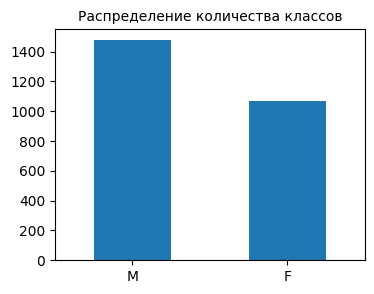

In [11]:
train.gender.value_counts().plot(kind='bar', rot=0, figsize=(4, 3));
plt.title('Распределение количества классов', fontsize=10);

In [12]:
# Видно, что в тренировочном наборе общее количество аудиозаписей с мужским голосом больше

In [13]:
# Создадим тестовое множество из gender (целевая переменная) и пути к аудио (audio)
test = make_dataset(male_test, fmale_test)
shuffle(test).head()

,gender,audio
33,F,resources/vox1_test_wav/wav/id10280\NXjT3732Ek...
265,F,resources/vox1_test_wav/wav/id10308\XQWpVt5n3I...
845,M,resources/vox1_test_wav/wav/id10279\4Q1IvdayPR...
121,F,resources/vox1_test_wav/wav/id10280\v0Q-VyO4Tj...
248,F,resources/vox1_test_wav/wav/id10308\sGqnn4WpQC...


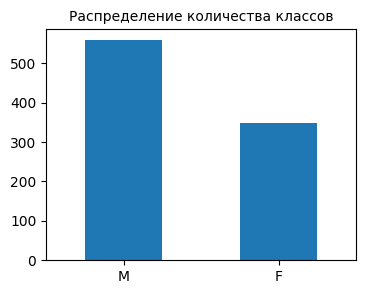

In [14]:
test.gender.value_counts().plot(kind='bar', rot=0, figsize=(4, 3));
plt.title('Распределение количества классов', fontsize=10);

In [15]:
# Видно, что в тестовом (как и тренировочном) наборе общее количество аудиозаписей с мужским голосом больше

## Выделение признаков

In [16]:
def get_audio(index: int, gender: str, data: pd.DataFrame):
    '''Получить путь к аудио по индексу из набора'''
    return data[data.gender == gender].audio.iloc[index]

In [17]:
n_fft, n_mfcc, hop_length = (2048, 23, 512)

In [18]:
# Сохраним значения stft и mfcc
melkwargs={
        'n_fft': n_fft,
        'n_mfcc': n_mfcc,
        'hop_length': hop_length,
}

def get_mfcc(signal, sr, **kwards):
    '''Получить значения mfcc'''
    return librosa.feature.mfcc(signal, sr=sr, **kwards)

def plot_audio_features(audio):
    '''Проиграть аудиозапись и отрисовать форму
    звуковой волны, спектрограмму и значения mfcc'''
    
    arr, sr = librosa.load(audio)
    display(ipd.Audio(arr, rate=sr))
    
    mfcc = get_mfcc(arr, sr, **melkwargs)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    librosa.display.waveshow(arr, ax=ax[0])
    spec = np.abs(librosa.stft(arr, n_fft=melkwargs['n_fft'],hop_length=melkwargs['hop_length']))
    spec2db = librosa.amplitude_to_db(spec)
    img = librosa.display.specshow(spec2db, x_axis='time', y_axis='log', ax=ax[1])
    librosa.display.specshow(mfcc, ax=ax[2])
    ax[0].set_title('звуковая волна')
    ax[1].set_title('спектограмма')
    ax[2].set_title('mfcc')
    fig.colorbar(img, ax=ax[1])
    
    return

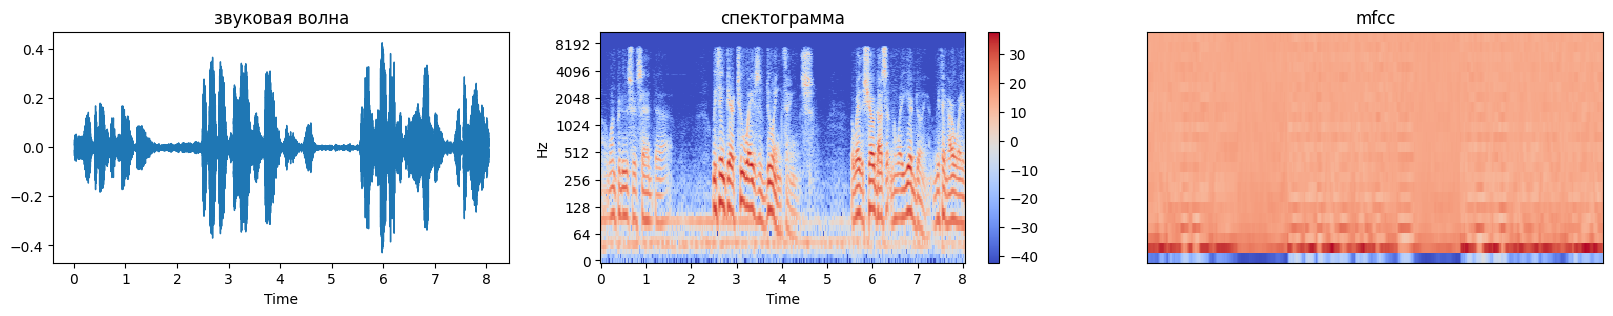

In [19]:
# мужская аудиозапись
plot_audio_features(get_audio(35, 'M', train))

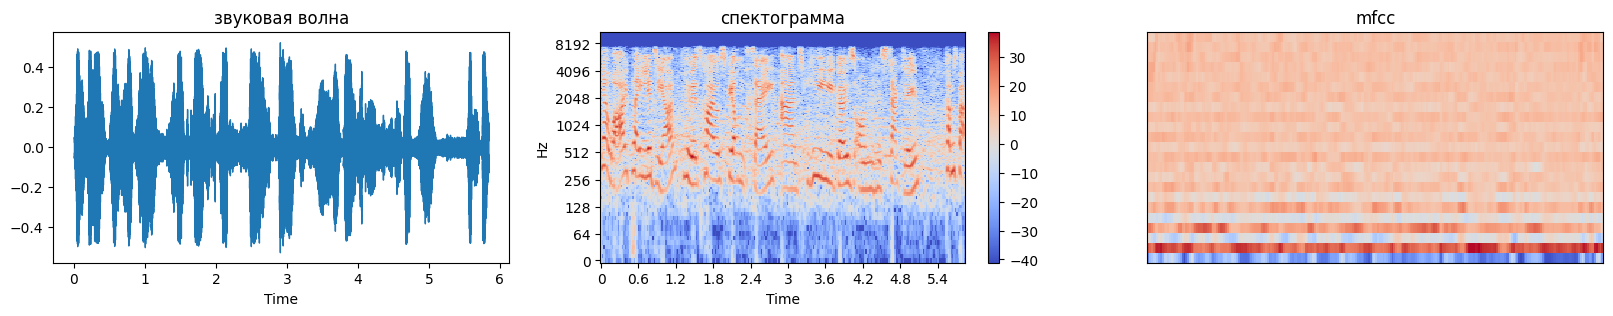

In [20]:
# Женская аудиозапись 
plot_audio_features(get_audio(35, 'F', train))

In [21]:
# Отрисовав характеристики нескольких аудозаписей, можно заметить на спектрограмме, что 
# часто мсужской голос имеет энергию на более низких частотах

In [22]:
def get_audio_features(dataset: pd.DataFrame, norm: bool):
    '''Получить признаки аудиозаписи в виде DataFrame'''
    features = []
    for audio in dataset.audio:
        arr, sr = librosa.load(audio)
        mfcc = get_mfcc(arr, sr, **melkwargs)
        mfcc = np.mean(mfcc, axis=1)
        if norm:
            mfcc = scale(mfcc)
        features.append(mfcc.tolist())
    n_mfcc = len(mfcc)
    features = pd.DataFrame(features)
    features.columns = [f'mfcc_{i}' for i in range(n_mfcc)]
    return pd.concat([dataset, features], axis=1)

In [23]:
%%time
# Формирование итогового набора
train_set = get_audio_features(train, True)
test_set = get_audio_features(test, True)

CPU times: total: 8min 46s
Wall time: 8min 26s


In [24]:
# Проверить количество коэффициентов mfcc
assert len(train_set.columns) == n_mfcc + 2

In [25]:
# Сохранить итоговый датасет
train_set.to_csv('train_set.csv')
test_set.to_csv('testn_set.csv')

## Обучение модели

In [26]:
# GMM как алгоритм кластеризации пытается моделировать набор входных данных
# путем нахождения смеси многомерных распределений Гаусса, 
# и абстрактно похож на k-means (только в отличие от нее под капотом содержит вероятностную модель)
# Алгоритм GMM содержит два простых шага:
#     1. E-шаг: для каждой точки находим веса, которые можно интерпретировать как вероятность принадлежать кластеру
#     2. M-шаг: обновить рсположение и форму кластеров с использованием весов
# Так как данный алгоритм может пропустить глобально оптимальное решение, то
# в данной работе используется 5 случайных инициализаций центров. Также важно выбрать 
# степени свободы формы кластеров, в данном случае covariance_type='diag'.

In [27]:
%%time

# GMM для мужских аудио
gmm_male = GMM(n_components=5, init_params='k-means++', n_init=5, covariance_type='diag')
gmm_male.fit(shuffle(train_set[train_set.gender == 'M'].loc[:, 'mfcc_0': ]))

# GMM для женских аудио
gmm_fmale = GMM(n_components=5, init_params='k-means++', n_init=5, covariance_type='diag')
gmm_fmale.fit(shuffle(train_set[train_set.gender == 'F'].loc[:, 'mfcc_0': ]))

CPU times: total: 203 ms
Wall time: 193 ms


GaussianMixture(covariance_type='diag', init_params='k-means++', n_components=5,
                n_init=5)

In [28]:
def evaluate(gmm_male, gmm_fmale, test, target):
    '''
    Рассчитать метрики:
        - accuracy
        - precision
        - recall
        - f1
    '''
     
    output = []
    for item in test:
        log_likelihood_1 = gmm_male.score([item])
        log_likelihood_2 = gmm_fmale.score([item])
        # рассчитать логарифм оношения правдоподобия 
        if  np.log(np.exp(log_likelihood_1) / np.exp(log_likelihood_2)) > 0:
            output.append('M')
        else:
            output.append('F')
    
    return classification_report(target, output)

In [29]:
# вычислить метрики на тренировочном наборе
print(evaluate(gmm_male, gmm_fmale, train_set.loc[:, 'mfcc_0': ].values, train_set.gender))

              precision    recall  f1-score   support

           F       0.90      0.93      0.91      1068
           M       0.95      0.92      0.93      1476

    accuracy                           0.93      2544
   macro avg       0.92      0.93      0.92      2544
weighted avg       0.93      0.93      0.93      2544



In [30]:
# вычислить метрики на тестовом наборе
print(evaluate(gmm_male, gmm_fmale, test_set.loc[:, 'mfcc_0': ].values, test_set.gender))

              precision    recall  f1-score   support

           F       0.70      0.69      0.70       349
           M       0.81      0.82      0.81       558

    accuracy                           0.77       907
   macro avg       0.76      0.75      0.75       907
weighted avg       0.77      0.77      0.77       907



In [31]:
def predict(datum, gmm_male=gmm_male, gmm_fmale=gmm_fmale, norm=True):
    '''Выполнить предсказание для наблюдения'''
    arr, sr = librosa.load(datum)
    mfcc = get_mfcc(arr, sr, **melkwargs)
    mfcc = np.mean(mfcc, axis=1)
    if norm:
        mfcc = scale(mfcc)
    log_likelihood_1 = gmm_male.score([mfcc])
    log_likelihood_2 = gmm_fmale.score([mfcc])
    if  np.log(np.exp(log_likelihood_1) / np.exp(log_likelihood_2)) > 0:
        return 'male'
    return 'fmale'

predict: fmale


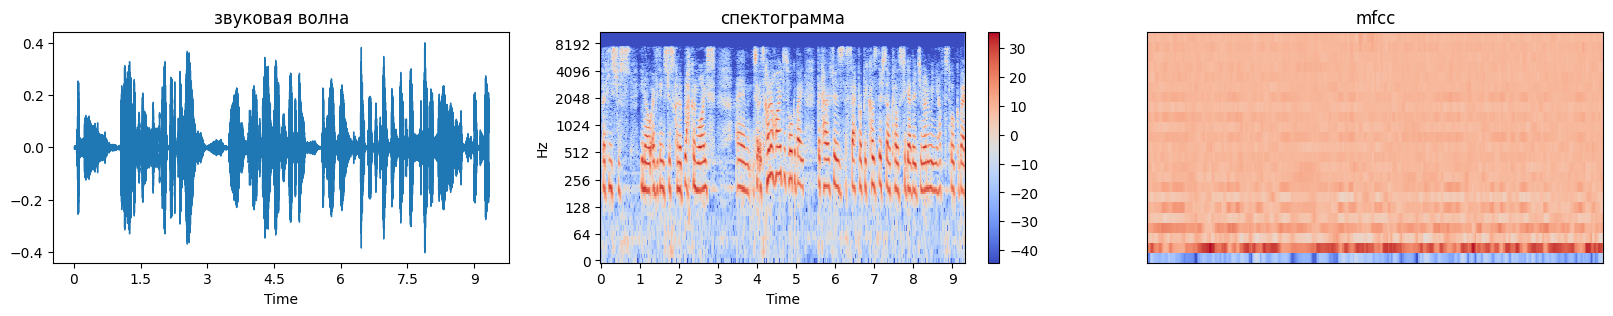

In [32]:
# Предсказание для женской аудио-записи из тестового набора (можно передать путь к любой аудиозаписи)
audio = get_audio(4, 'F', test)
plot_audio_features(audio)
print(f'predict: {predict(audio)}')

predict: male


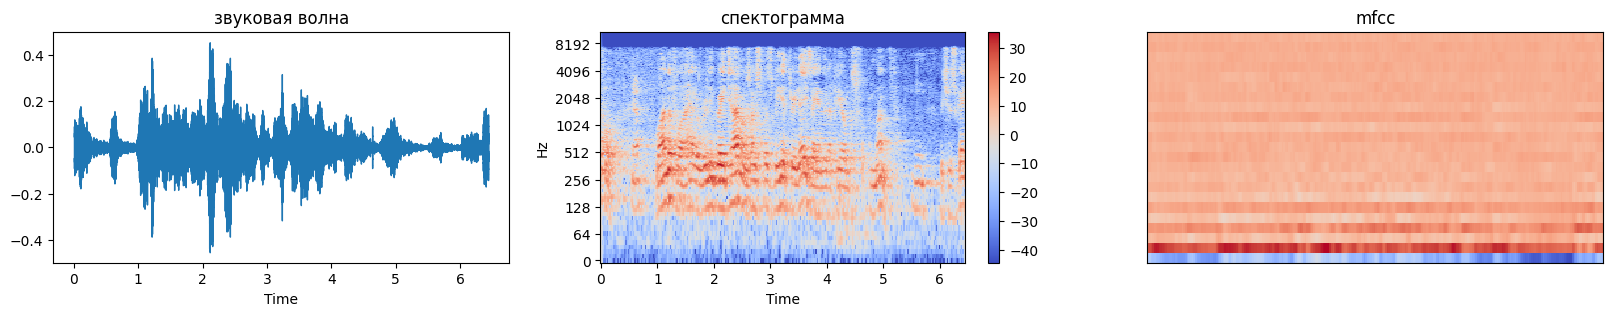

In [33]:
# Предсказание для мужской аудио-записи из тестового набора (можно передать путь к любой аудиозаписи)
audio = get_audio(2, 'M', test)
plot_audio_features(audio)
print(f'predict: {predict(audio)}')

In [34]:
# Важным вопросом, который встает на этапе обучения GMM, является выбор количества компонент
# Чтобы избежать переобучения - можно попробовать использовать аналитические критерии BIC и AIC
# Оптимальное значение кластеров минимизирует AIC или BIC
# Судя по графикам, n_components ~= 30 является оптимальной для male_gmm и fmale_gmm
# Однако использование аналитических критериев не освобождает от рассчета метрик
# И эксперименты показали, что результат классификации одниковый при n_components = 5 и при n_components = 60
# Мы предпочтем более "простую" модель

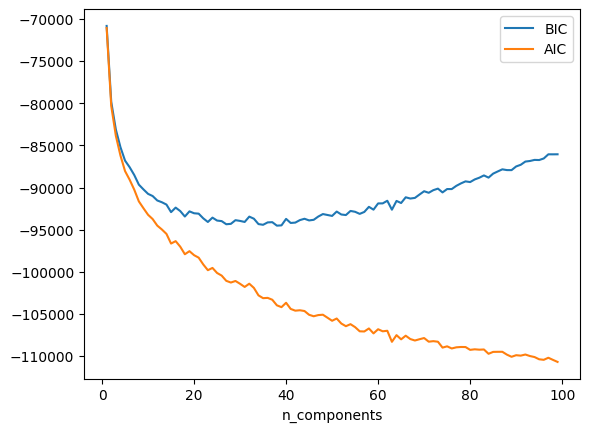

In [35]:
def plot_bic_aic(X: pd.DataFrame, gender: str):
    n_components = np.arange(1, 100)
    X_moon = shuffle(X[X.gender == gender].loc[:, 'mfcc_0': ])
    models = [
        GMM(n_components=n, init_params='k-means++', n_init=5, covariance_type='diag').fit(X_moon) for n in n_components
    ]
    plt.plot(n_components, [m.bic(X_moon) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(X_moon) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    return

# Для мужской GMM
plot_bic_aic(train_set, 'M')

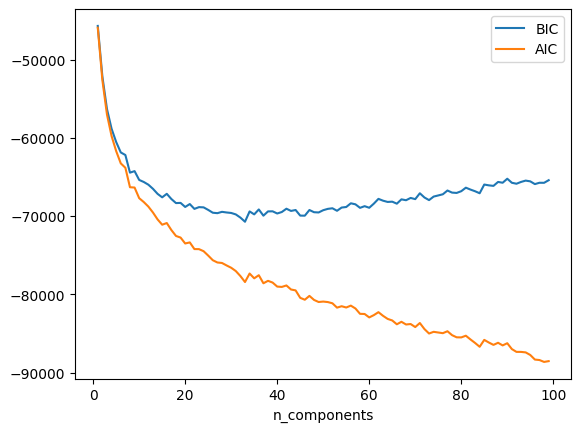

In [36]:
# Для женской GMM
plot_bic_aic(train_set, 'F')

In [37]:
# На самом деле, GMM можно рассматривать как алгоритм оценки плотности, 
# и его можно использовать как порождающую вероятностную модель, которая описывает распределение данных
# (хотя генерация аудиозаписей из GMM навряд ли получится, наверно потому, что сигнал имеет жесткую временную структуру)
# Для того, чтобы посмотреть, как GMM может моделировать общее распределение входных данных,
# в качестве примера было решено визуализировать результат работы на предоставленном наборе данных
# после использования UMAP-алгоритма.
# Данный метод моделирует объект высокой размерности низкоразмерной точкой так,
# что похожие объекты оказываются ближе друг к другу, чем не похожие

In [38]:
def plot_gmm(gmm, dataset, ax):
    '''Отрисовка многомерных распределений'''
    from matplotlib.patches import Ellipse
    labels = gmm.fit(dataset).predict(dataset)
    ax.scatter(dataset[:, 0], dataset[:, 1])
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covariance, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        else:
            angle = 0
            width, height = 2 * np.sqrt(covariance)
        for i in range(1, 4):
            ax.add_patch(Ellipse(pos, i * width, i * height, angle, alpha=w*w_factor))

In [39]:
reducer_male = umap.UMAP(n_components=2)
reducer_fmale = umap.UMAP(n_components=2)
reduce_male = reducer_male.fit_transform(train_set[train_set.gender == 'M'].loc[:, 'mfcc_0': ])
reduce_fmale = reducer_fmale.fit_transform(train_set[train_set.gender == 'F'].loc[:, 'mfcc_0': ])

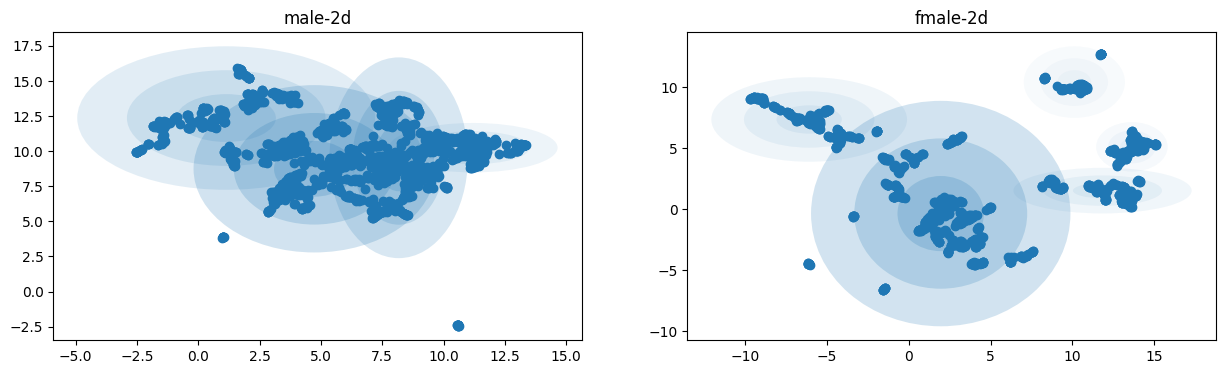

In [40]:
# Показать результат работы GMM
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_gmm(GMM(n_components=5, init_params='k-means++', n_init=5, covariance_type='diag', reg_covar=1e-5), 
         reduce_male, ax=ax[0])
plot_gmm(GMM(n_components=5, init_params='k-means++', n_init=5, covariance_type='diag', reg_covar=1e-4),
         reduce_fmale, ax=ax[1])
ax[0].set_title('male-2d')
ax[1].set_title('fmale-2d');

## Выводы

In [41]:
# Анализируя значения полученных метрик (в первую очередь accuracy) на трейне и тесте, можно сказать, что модель получилась
# переобученной (даже после изменений гиперпараметров). В целом, дисбаланс классов также может влиять на данную метрику.
# Следует отметить, что количество мелл-спектральных харакеристик 
# также являются своего рода гиперпарматером, который следует устанавливать наиболее подходящим образом.
# А также возможно, что увеличение размеров датасета (путем добавления дикторов) сделает ее более репрезентативной для GMM.
# Для получения более точных результатов работы модели, в дальнейшем следует провести кросс-валидацию, 
# а также выполнить подбор гиперпараметров с помощью GridSearch или байесовской оптимизации.